TensorFlow:1.13.1
NumPy:1.16.3
Scikit Learn:0.21.2
model : Y = 64.27156067 X + 1.94639361
for test data: MSE = 485.74005127, R2 = 0.87806702


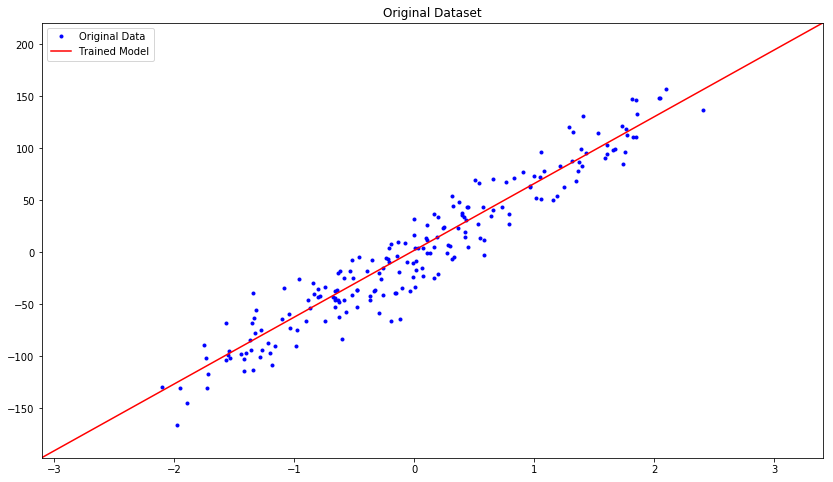

AttributeError: Unknown property lable

<Figure size 1008x576 with 0 Axes>

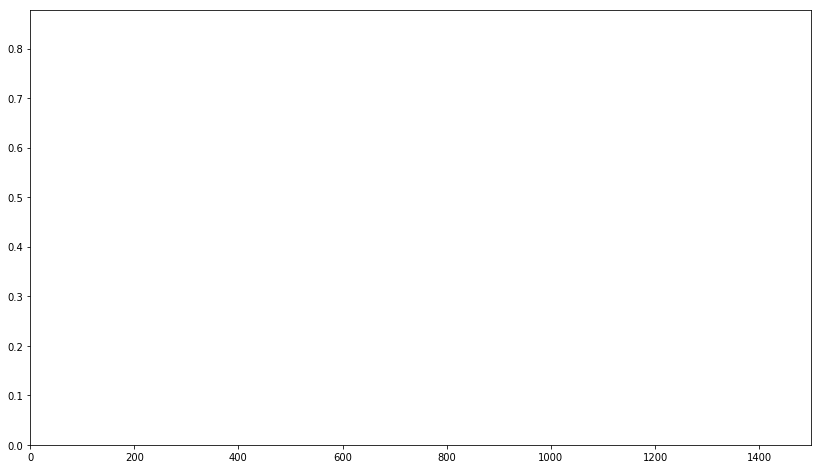

In [34]:
import tensorflow as tf
print('TensorFlow:{}'.format(tf.__version__))
import numpy as np
print('NumPy:{}'.format(np.__version__))

import sklearn as sk
print('Scikit Learn:{}'.format(sk.__version__))
from sklearn import datasets as skds
from sklearn import model_selection as skms
import matplotlib.pyplot as plt


X, y = skds.make_regression(
    n_samples=200, n_features=1, n_informative=1, n_targets=1, noise=20.0)

if (y.ndim == 1):
    y = y.reshape(-1, 1)
    
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, 
                                                         test_size=.4,
                                                        random_state=123)

num_outputs = y_train.shape[1]
num_inputs = X_train.shape[1]

# x_tensor行数没有确定，列数为num_inputs
x_tensor = tf.placeholder(dtype=tf.float32,
                         shape=[None, num_inputs],
                         name='x')

# y_tensor行数没有确定， 列数为num_outputs
y_tensor = tf.placeholder(dtype=tf.float32,
                         shape=[None, num_outputs],
                         name='y')

# w维数为num_inputs乘以num_outputs
w = tf.Variable(tf.zeros([num_inputs, num_outputs]),
               dtype=tf.float32,
               name='w')
# b维数为num_outputs
b = tf.Variable(
    tf.zeros([num_outputs]),dtype=tf.float32, name='b')

# 定义模型  (x_tensor * W + b)
model = tf.matmul(x_tensor, w) + b

# 使用均方误差作为损失函数
# y的实际值与估计值的差别被称为残差（residual），损失函数计算的是残差的平方的均值
# model-y_tensor： 计算残差
# tf.reduce_mean()：计算平均值
loss = tf.reduce_mean(tf.square(model - y_tensor))

# 均方误差(mean squared error, mse)
# r平方(r-squared, rs)
mse = tf.reduce_mean(tf.square(model - y_tensor))
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# 迭代次数
num_epochs = 1500

# 通过估计得到的w，b
w_hat = 0
b_hat = 0

# loss_epochs：总误差值 
# mse_epochs：基于测试集上模型的均方误差
# rs_epochs：基于测试集上模型的r平方值
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0
rs_score = 0

with tf.Session() as tfs:
    tf.global_variables_initializer().run()
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val, _ = tfs.run([loss,optimizer], feed_dict=feed_dict)
        loss_epochs[epoch] = loss_val
        
        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        # 计算测试数据的预测值的均方误差和r平方值
        mse_score, rs_score = tfs.run([mse, rs], feed_dict=feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score
    # 循环结束，保存w和b值，用于之后的绘图
    w_hat, b_hat = tfs.run([w, b])
    w_hat = w_hat.reshape(1)
    
print('model : Y = {0:.8f} X + {1:.8f}'.format(w_hat[0], b_hat[0]))
print('for test data: MSE = {0:.8f}, R2 = {1:.8f}'.format(mse_score, rs_score))
    
    

#绘图估计的模型和原始数据
plt.figure(figsize=(14, 8))
plt.title('Original Dataset')
x_plot = [np.min(X)-1, np.max(X)+1]
y_plot = w_hat *x_plot + b_hat
plt.axis([x_plot[0], x_plot[1], y_plot[0], y_plot[1]])
plt.plot(X, y, 'b.', label='Original Data')
plt.plot(x_plot, y_plot, 'r-', label='Trained Model')
plt.legend()
plt.show()

# 在每次迭代中绘制训练数据和测试数据的均方误差
plt.figure(figsize=(14, 8))
# plt.axis([0, num_epochs, 0, np.max(loss_epochs)])
# plt.plot(loss_epochs, lable='Loss on X_train')
# plt.title('Los in Iterations')
# plt.xlabel('# Epoch')
# plt.ylabel('MSE')

# plt.axis([0, num_epochs, 0, np.max(mse_epochs)])
# plt.plot(mse_epochs, lable='MSE on X_test')
# plt.xlabel('# Epoch')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

# 绘制r平方值
plt.figure(figsize=(14, 8))
plt.axis([0, num_epochs, 0, np.max(rs_epochs)])
plt.plot(rs_epochs, lable='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()
plt.show()